# **Data Import**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uom190346a/water-quality-and-potability")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/uom190346a/water-quality-and-potability/versions/2


# **Data Understanding**

In Data Understanding; the key aspects looked at were `loading the dataset`, `previewing the beginning and the end of the data`, `understanding the number of columns`, `the data types of each column`, `null count (missing values)` and `checking for duplicates`

Loading and previewing the first 5 records of the dataframe

In [2]:
import pandas as pd

df = pd.read_csv(path + "/water_potability.csv")
df.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

Previewing the last 5 records of the dataframe. Noticeable from the preview is that the target class `Potability`, the two labels `0` and `1` appear to sequentiall separated. This issue will be handled later in data preparation and feature engineering section

In [3]:
df.tail()

ph    Hardness        Solids  Chloramines     Sulfate  \
3271  4.668102  193.681735  47580.991603     7.166639  359.948574   
3272  7.808856  193.553212  17329.802160     8.061362         NaN   
3273  9.419510  175.762646  33155.578218     7.350233         NaN   
3274  5.126763  230.603758  11983.869376     6.303357         NaN   
3275  7.874671  195.102299  17404.177061     7.509306         NaN   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
3271    526.424171       13.894419        66.687695   4.435821           1  
3272    392.449580       19.903225              NaN   2.798243           1  
3273    432.044783       11.039070        69.845400   3.298875           1  
3274    402.883113       11.168946        77.488213   4.708658           1  
3275    327.459760       16.140368        78.698446   2.309149           1

The next 4 code blocks list the columns, their data types, non-null count (not empty) as well as the duplicates count in the dataset

In [4]:
df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [5]:
df.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

It is clear that all columns are continuous
The dataframe info below also shows that some columns having missing values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [7]:
df.duplicated().sum()

np.int64(0)

# **Data Cleaning**

I have used box-plots to check for outliers such any data point that falls outside the whisker will confirm the presence of extreme outlier values

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_outlier(df):
  fig, axes = plt.subplots(len(df.columns), 1, figsize=(10, len(df.columns)*8))
  for i, col in enumerate(df.columns):
      sns.boxplot(df[col], ax=axes[i])
      axes[i].set_title(f'Box Plot of {col}')
  plt.tight_layout()
  plt.show()


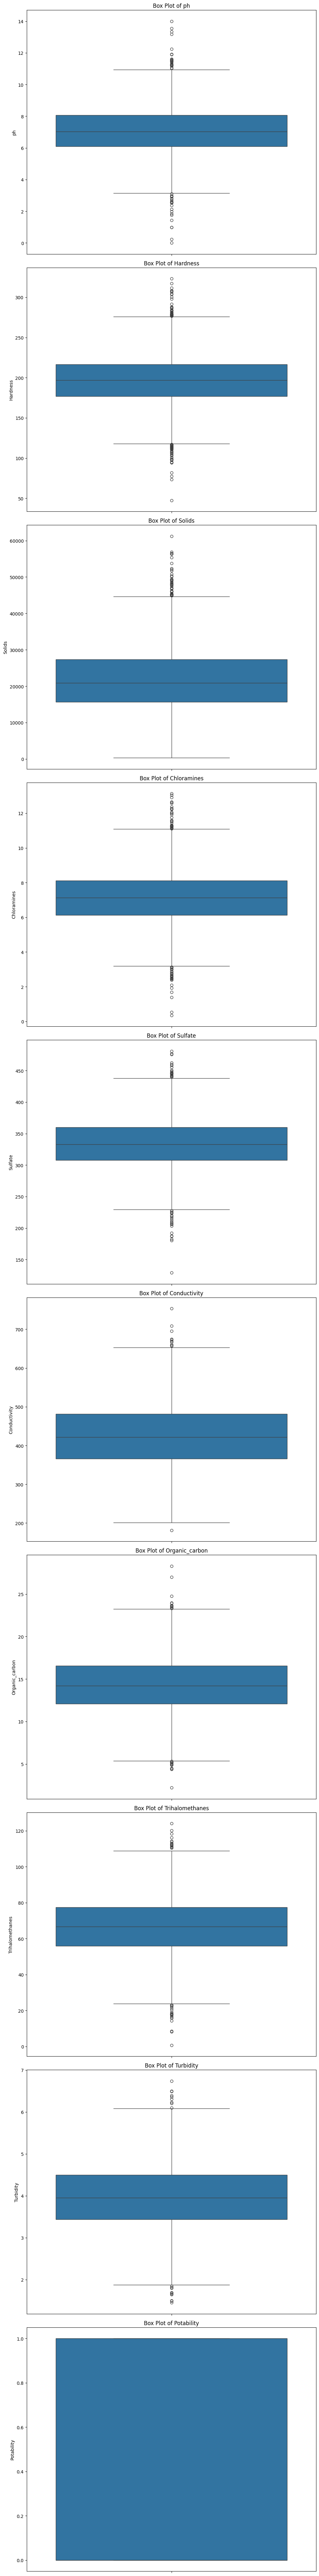

In [9]:
visualize_outlier(df)

As shown in the box plots above, each of the feature columns appears to have outlier values, something that needs cleaning to prevent misleading correlation matrix as well as model predictions.
While there exists several ways of removing outliers, I have went on to use Interquartile range that is favoribly used in handling outliers https://www.freecodecamp.org/news/how-to-detect-outliers-in-machine-learning/, https://www.kaggle.com/code/vinayakshanawad/random-forest-with-bootstrap-sampling-for-beginner/notebook

In [10]:
df_cleaned = df.copy()

feature_columns = [col for col in df_cleaned.columns if col != 'Potability']

for col in feature_columns:
  Q1 = df_cleaned[col].quantile(0.25)
  Q3 = df_cleaned[col].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]


In the code block above, for all feature columns I calculated interquartile range by subtracting the 3rd Quartile from the 1st Quartile which I then used to calculate the upper and lower bounds. Any values that fall above/under this 2 bounds is then filtered out as an outlier

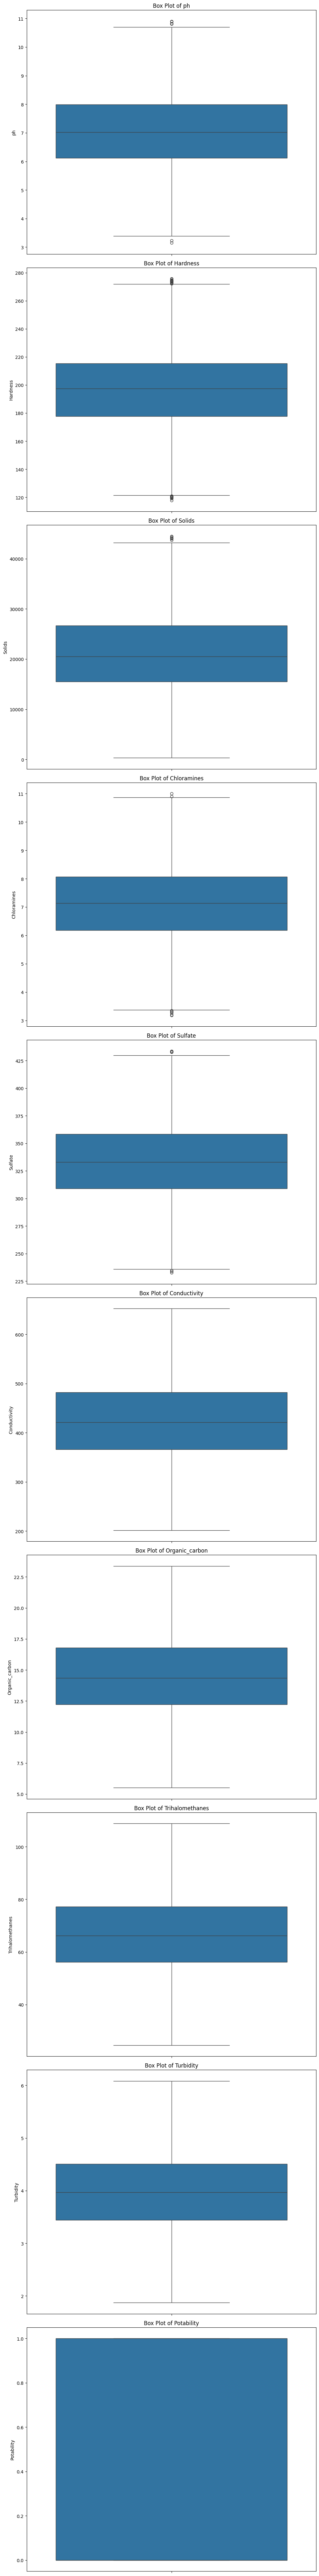

In [11]:
visualize_outlier(df_cleaned)

Having removed the outliers, the box plots now have minimal data points exceeding off the whiskers

In addition to checking and removing outliers, I also checked for missing values as well as the class label distribution in the code blocks below
The cleaned dataframe has no missing values as any records that may have had any missing values were inadvertenly removed while handling outliers. On the other hand, while the classes are not exactly even there are in the ration of 60/40

In [12]:
df_cleaned.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [13]:
df_cleaned['Potability'].value_counts()

Potability
0    1091
1     700
Name: count, dtype: int64

# **Exploratory Data Analysis**

## Summary Statistics

In [14]:
df_cleaned.describe().transpose()

count          mean          std         min           25%  \
ph               1791.0      7.072984     1.438241    3.148712      6.114756   
Hardness         1791.0    196.253687    29.404867  117.791230    177.723599   
Solids           1791.0  21482.187746  7999.807027  320.942611  15473.227705   
Chloramines      1791.0      7.122492     1.422362    3.181183      6.185317   
Sulfate          1791.0    333.679981    37.159380  232.548814    308.929791   
Conductivity     1791.0    425.583862    79.941616  201.619737    366.107986   
Organic_carbon   1791.0     14.424836     3.227881    5.512040     12.233042   
Trihalomethanes  1791.0     66.398930    15.483895   24.532773     56.158542   
Turbidity        1791.0      3.972049     0.759663    1.872573      3.444735   
Potability       1791.0      0.390843     0.488076    0.000000      0.000000   

                          50%           75%           max  
ph                   7.025822      7.991063     10.905076  
Hardness           197.374482    215.442923    275.746716  
Solids           20511.369240  26698.807540  44499.728710  
Chloramines          7.135063      8.065289     10.999995  
Sulfate            332.877574    358.242592    433.633900  
Conductivity       421.417352    481.877672    652.537592  
Organic_carbon      14.354595     16.786244     23.373265  
Trihalomethanes     66.165224     77.274009    108.849568  
Turbidity            3.969740      4.510500      6.083772  
Potability           0.000000      1.000000      1.000000

I used `describe` function to show summary statistics of the data so as to understand and explore further the data's distribution, variability and spread. The closeness in the mean and median (50%) values show that for most features, the have a normal distribution. The mean of different features also highlights the disparity in feature values i.e `Solids` have a mean of 21482.19 while `Turbidity` have a mean of 3.97. Normalization is a possible isolation to fix this. Standard Deviation, Min and Max values also show the variability and spread of values. For `Solids` a minimum of 320.94 and a maximum of 44499.73, shows high variability

## Univariate Analysis

While summary statictics provided me with numerical insights, to better understand columns characteristics like skewness and distribution shape, I used histogram plots that also have a kernel density estimation for the visualize the data

In [15]:
def visualize_distribution(df):
  fig, axes = plt.subplots(len(df.columns), 1, figsize=(10, len(df.columns)*8))
  for i, col in enumerate(df.columns):
      sns.histplot(df[col], ax=axes[i], kde=True)
      axes[i].axvline(df[col].mean(), color='red', linewidth=2, label='Mean')
      axes[i].axvline(df[col].median(), color='blue', linestyle='dashed', linewidth=2, label='Median')
      axes[i].legend()
  plt.tight_layout()
  plt.show()

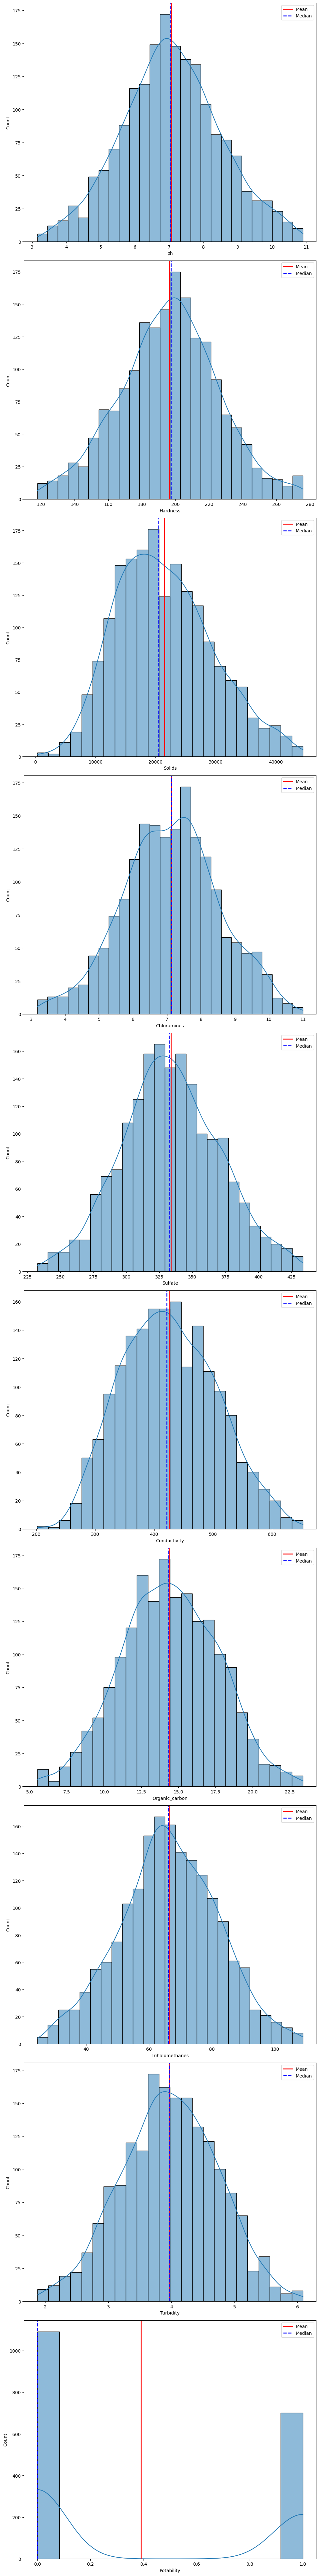

In [16]:
visualize_distribution(df_cleaned)

The above visualizations support the theoritical insights derived from the summary statistics. Apart chloramines that have a slightly angled bell-curve, all features have somewhat like a bell-curve conforming to the normal distribution assumption. The mean and median lines been close to each other further support this observation

## Multivariate Analysis

Having understood the data quality for each feature, I continued to use scatterplot matrix and a correlation heatmap to understand the relationship between features.The two labels are dinguished by color to understand each variable's relationship with it. Kernel Density plots also show the distribution for each variable for the 2 classes

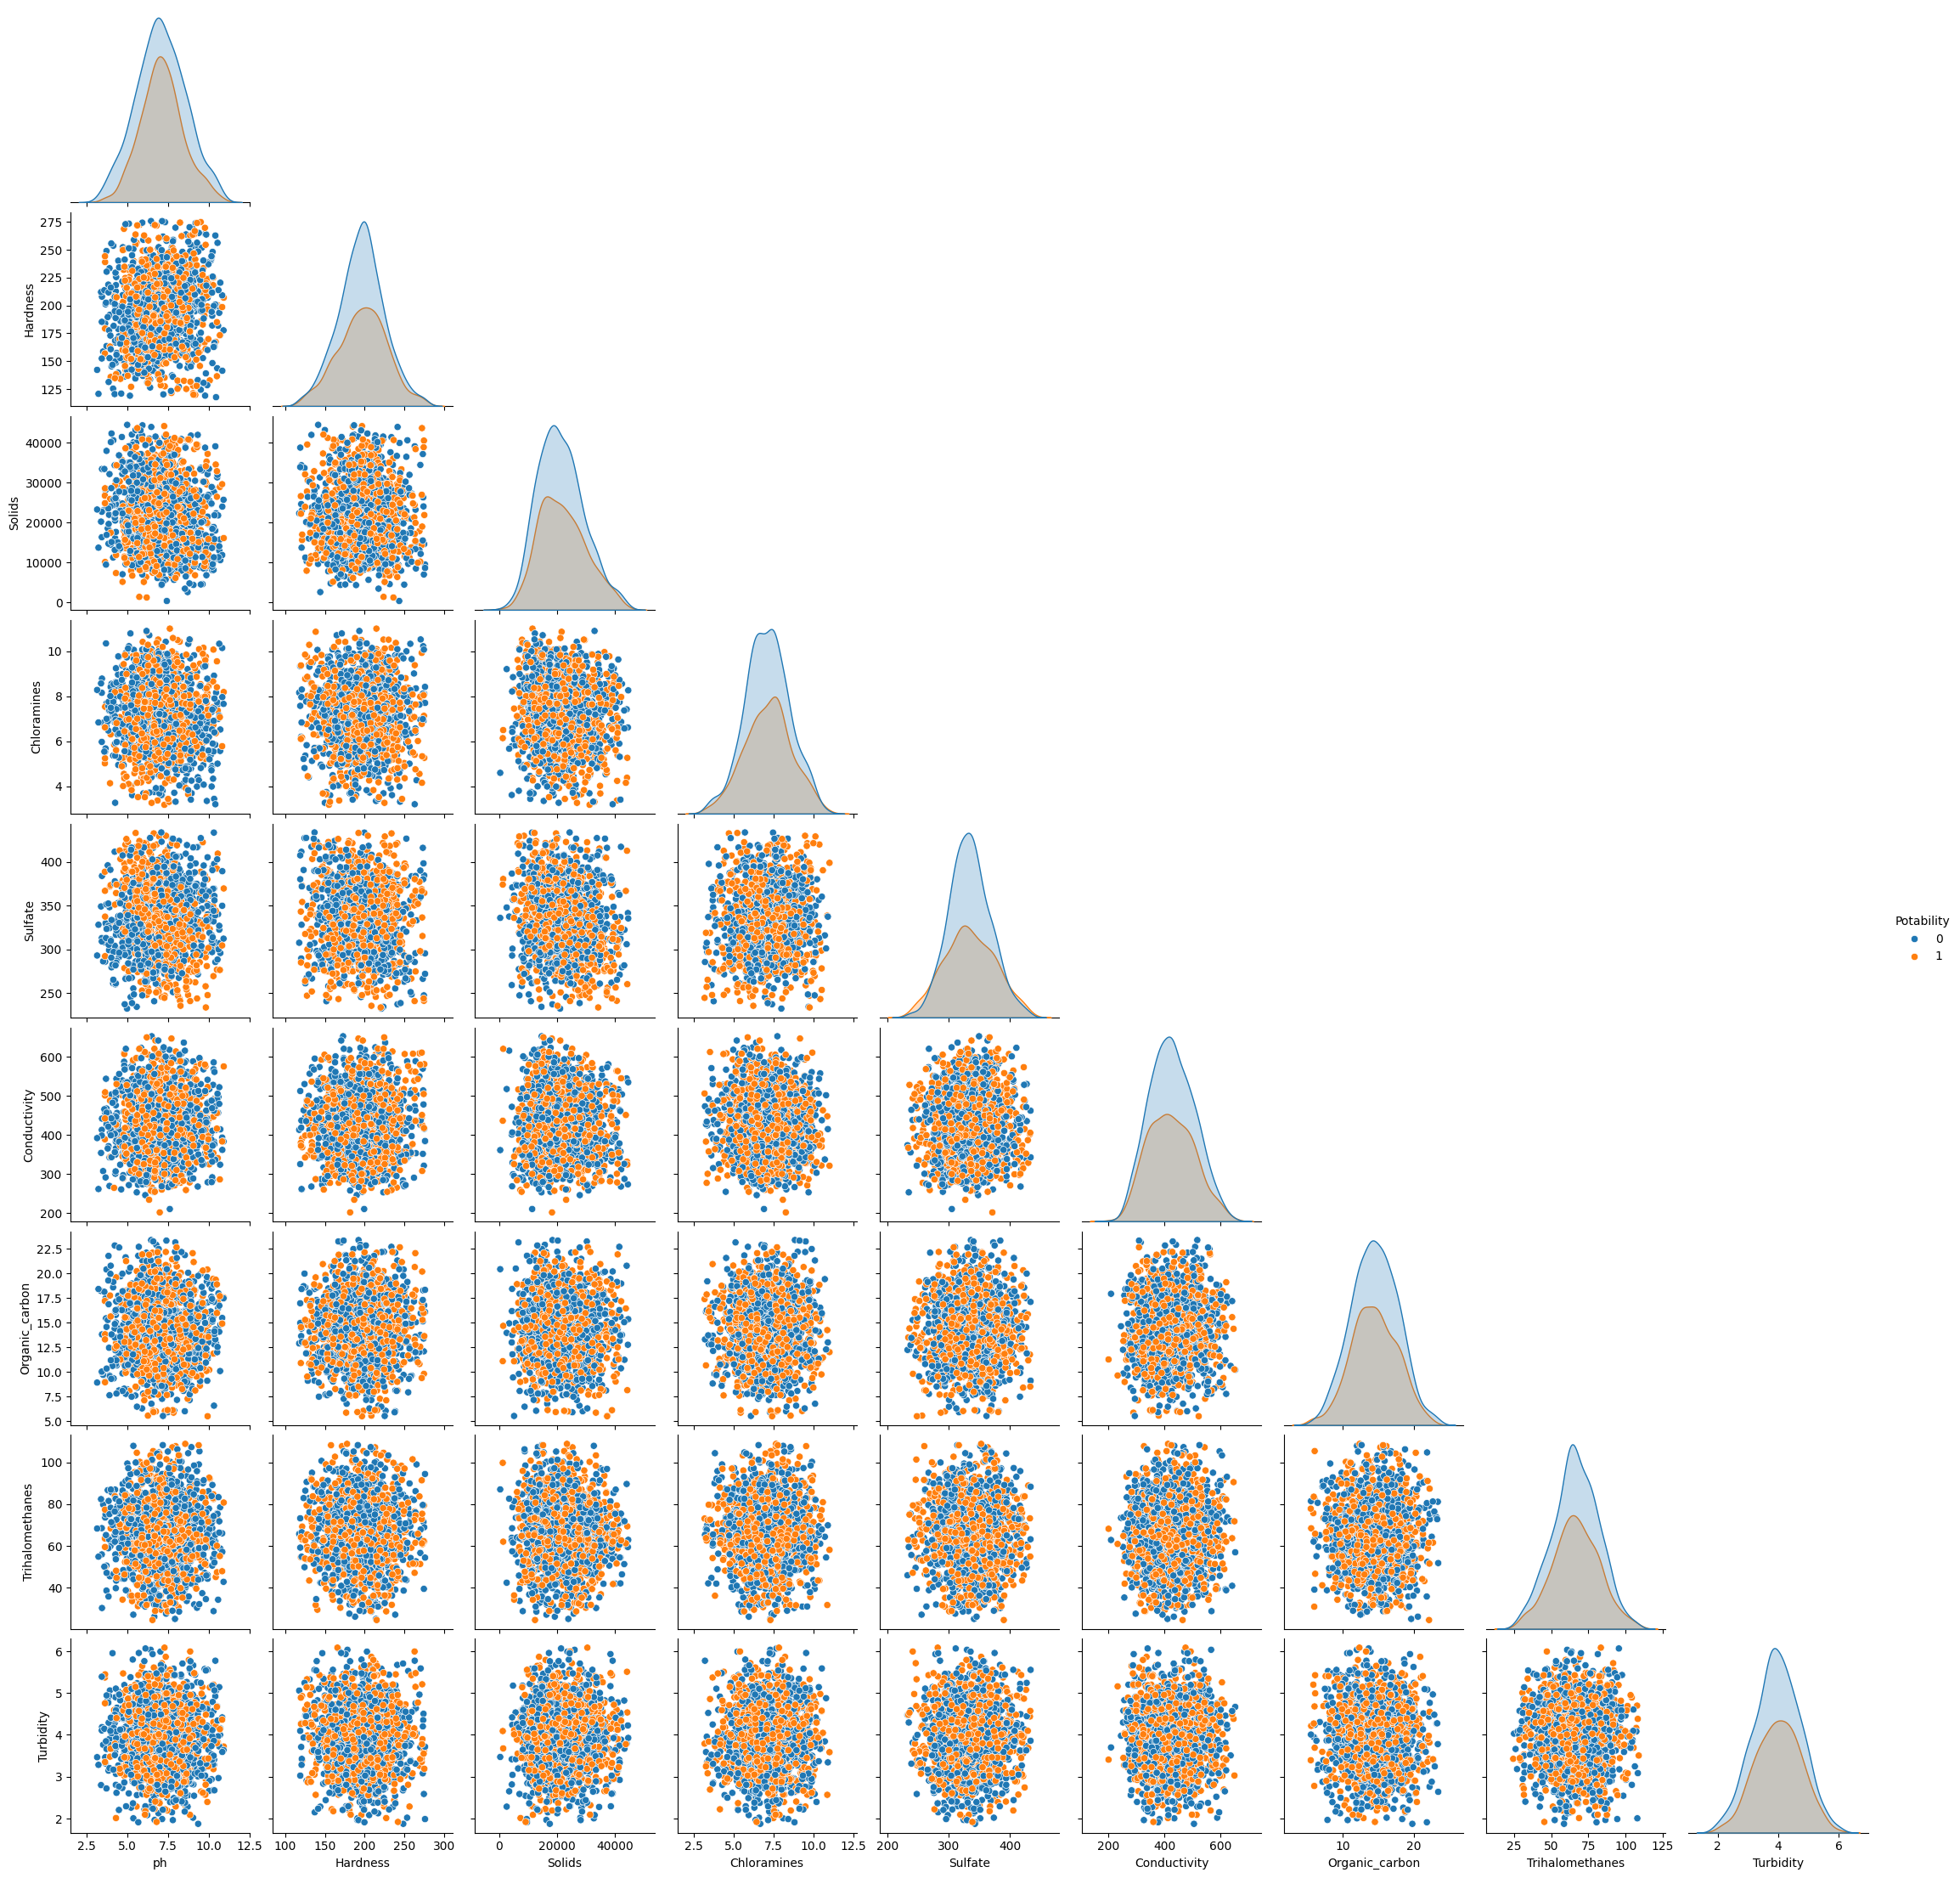

In [17]:
sns.pairplot(df_cleaned, hue='Potability', diag_kind='kde', corner=True)

As shown in the figure above, the distribution of two labels overlap each for all variables which in turn highlights lack of clear separation of the two classes. The diagonal KDE plots also shows similar distributions for both classes across all parameters

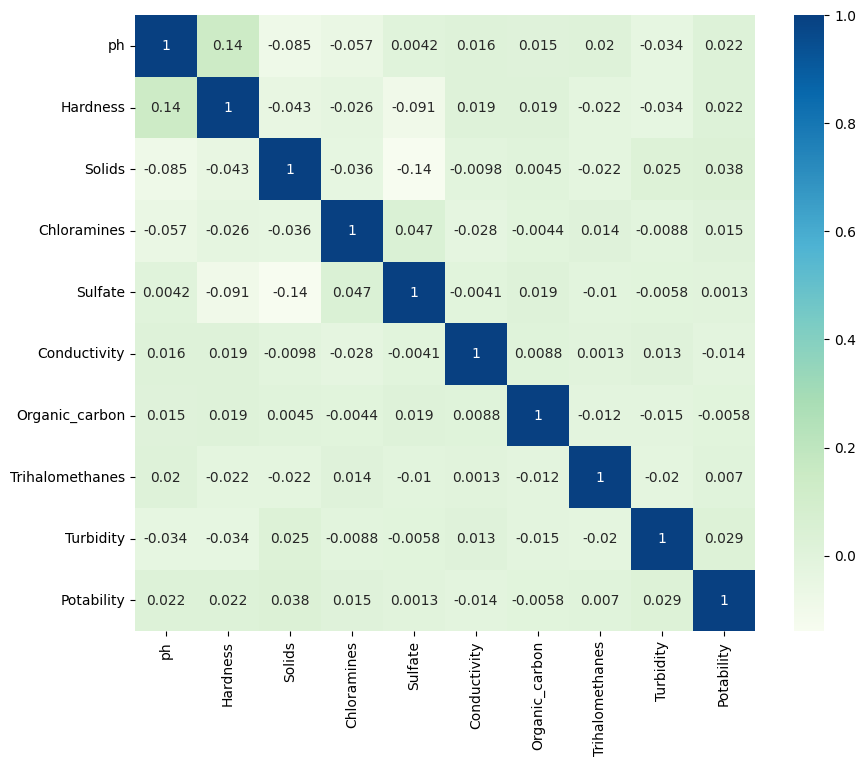

In [18]:
corr = df_cleaned.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='GnBu')
plt.show()

I also created a correlation heatmap between the variables as well as between variables and the target with correlation coefficients (-1 to 1) showing the correlation strength.
Most features show weak correlation with the `Potability` which is the target class. `ph` and ``Hardness` have a the strongest relationship (0.14) which is still weak positive correlation. Conversely, the strongest negative correlation is between `Solids` and `Sulfate` (-0.14). The absence of strong correlation outlines lack of clear linear relationship between the features

# **Data Preparation and Feature Engineering**

To understand the implication of lack of shuffling, a trained a decision tree model and evaluated its performance. `57.06%` accuracy was quite low prompted me to shuffle the data

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def create_model(df):

  X = df.drop('Potability', axis=1)
  y = df['Potability']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  model = DecisionTreeClassifier(random_state=42)
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy)

In [20]:
create_model(df_cleaned)

Accuracy: 0.570631970260223


The cleaned dataframe is shuffled with a random seed and the stored as a shuffle dataframe. The shuffled dataframe had `61.52%`, a `+4.46%` increase from the un-shuffled data.

In [21]:
from sklearn.utils import shuffle

df_shuffled = shuffle(df_cleaned, random_state=42)

In [22]:
create_model(df_shuffled)

Accuracy: 0.6152416356877324


Having noted earlier that there is huge value variability amongst different features in the dataset, I created a normalization function that uses MinMax normalization. The effect of normalization on performance is then tested across different feature sets.

In [23]:
from sklearn.preprocessing import MinMaxScaler

def normalize_dataframe(df):
  scaler = MinMaxScaler()

  X = df.drop('Potability', axis=1)
  y = df['Potability']

  X_normalized = scaler.fit_transform(X)

  df_normalized = pd.DataFrame(X_normalized, columns=X.columns)
  df_normalized['Potability'] = y.values

  return df_normalized


# **Modelling - Model Creation, Training and Feature Importance Visualization**

The code below contains the main function to create and evaluate the decision tree model.
It splits the data into `70/30` training/test split, creates and trains the classifier, evaluates its performance on the test data, records feature importance on which variables affect the model's predictions most before finally storing the accuracy into a list of model results for comparison

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

model_results = [] #list to store model performance

# function to train and evaluate the model
def create_model(df, model_name, visualize=False):

    # Splitting the data
    X = df.drop('Potability', axis=1)
    y = df['Potability']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Train and Test split 70/30 ratio with random seeding

    # Training the model
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Evaluating the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Storing Feature Importance
    feature_importance = dict(zip(X.columns, model.feature_importances_))

    # Storing the Model accuracy
    model_results.append({"Model": model_name, "Accuracy": accuracy})

    # Print results
    print(f"Model: {model_name}, Accuracy: {accuracy}")

    # Displaying Feature Importance
    if visualize:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(feature_importance.values()), y=list(feature_importance.keys()), palette="viridis")
        plt.xlabel("Feature Importance Score")
        plt.ylabel("Features")
        plt.title(f"Feature Importance - {model_name}")
        plt.show()

    return feature_importance


Below, 5 models are trained
1. Original Un-normalized features
2. Original Normalized features
3. Top 5 features Un-Normalized
4. Top 5 features Normalized
5. Composite features

The results and accuracies are then discussed in the results section

## Non-Normalized Data Model and its Feature Importance

Model: Non-Normalized Data, Accuracy: 0.6152416356877324


<ipython-input-24-501a7d235249>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(feature_importance.values()), y=list(feature_importance.keys()), palette="viridis")


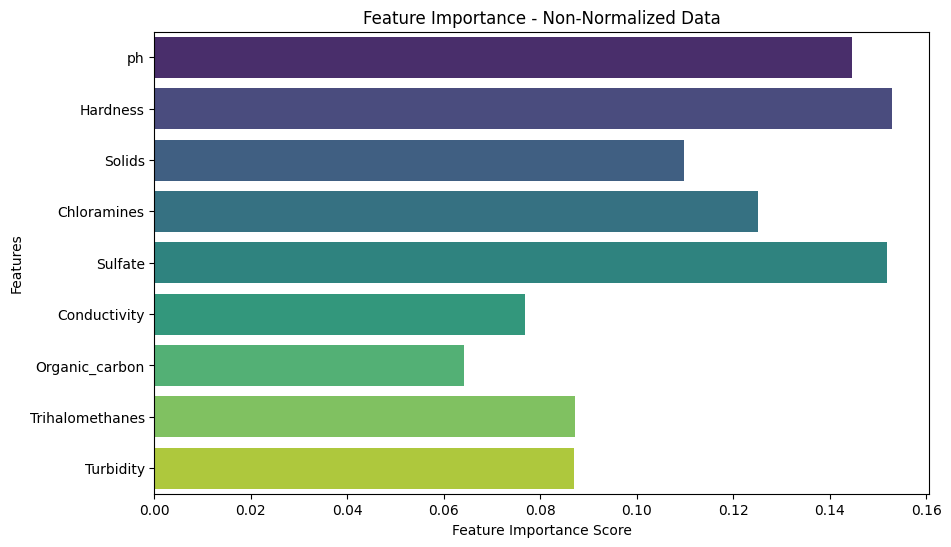

In [25]:
df_shuffled = shuffle(df_cleaned, random_state=42)
feature_importance = create_model(df_shuffled, "Non-Normalized Data", visualize=True)

In addition to the model's accuracy (61.52%), the feature importance is visualized. `ph`, `Hardness` and `Sulfate` are well highlighted as the most important features.

## Normalized Data Model

In [26]:
df_normalized = normalize_dataframe(df_shuffled)
create_model(df_normalized, "Normalized Data")


Model: Normalized Data, Accuracy: 0.6152416356877324


{'ph': np.float64(0.1446059215825446),
 'Hardness': np.float64(0.1530297067110741),
 'Solids': np.float64(0.1098701773392518),
 'Chloramines': np.float64(0.12522249739879787),
 'Sulfate': np.float64(0.15198793971788438),
 'Conductivity': np.float64(0.07684759537001261),
 'Organic_carbon': np.float64(0.0641568630934543),
 'Trihalomethanes': np.float64(0.08720916358273534),
 'Turbidity': np.float64(0.08707013520424502)}

## Top 5 Most Important Features Model (Non-Normalized)

In [27]:
top_features = sorted(feature_importance, key=feature_importance.get, reverse=True)[:5]
df_top_features = df_shuffled[top_features + ['Potability']]
create_model(df_top_features, "Top Features (Non-Normalized)")

Model: Top Features (Non-Normalized), Accuracy: 0.637546468401487


{'Hardness': np.float64(0.20559641949880864),
 'Sulfate': np.float64(0.22420685935817078),
 'ph': np.float64(0.20328921276656195),
 'Chloramines': np.float64(0.17577023990823645),
 'Solids': np.float64(0.19113726846822213)}

## Top 5 Most Important Features Model (Normalized)

In [28]:
df_top_features_norm = df_normalized[top_features + ['Potability']]
create_model(df_top_features_norm, "Top Features (Normalized)")

Model: Top Features (Normalized), Accuracy: 0.637546468401487


{'Hardness': np.float64(0.20559641949880864),
 'Sulfate': np.float64(0.22420685935817078),
 'ph': np.float64(0.20328921276656195),
 'Chloramines': np.float64(0.17577023990823645),
 'Solids': np.float64(0.19113726846822213)}

## Original Features + Composite Features Model

For 2 extra features were created to act as composite features:
1. A combination of `ph` and `Hardness` two of the Top 5 features. These two features also had a weak positive correlation of 0.14
2. `Turbidity` and `Trihalomethanes` were also chosen to make a composite feature as they had exactly feature importance value which led to the assumption that combining them in some way may affect model's performance

In [29]:
df_composite = df_shuffled.copy()
df_composite["hardness_ph"] = df_composite["Hardness"] + df_composite["ph"]
df_composite["clarity_risk"] = df_composite["Turbidity"] / (df_composite["Trihalomethanes"])

create_model(df_composite, "Composite Features")

Model: Composite Features, Accuracy: 0.620817843866171


{'ph': np.float64(0.13643266284516203),
 'Hardness': np.float64(0.04609647443008439),
 'Solids': np.float64(0.0807660686699723),
 'Chloramines': np.float64(0.11285496956187535),
 'Sulfate': np.float64(0.15300866851687256),
 'Conductivity': np.float64(0.079976253101416),
 'Organic_carbon': np.float64(0.08071913752487397),
 'Trihalomethanes': np.float64(0.07025331822264318),
 'Turbidity': np.float64(0.07484941583662393),
 'hardness_ph': np.float64(0.08590283073252528),
 'clarity_risk': np.float64(0.07914020055795097)}

# **Results**


In [30]:
df_results = pd.DataFrame(model_results)
print("\nModel Performance:\n", df_results)


Model Performance:
                            Model  Accuracy
0            Non-Normalized Data  0.615242
1                Normalized Data  0.615242
2  Top Features (Non-Normalized)  0.637546
3      Top Features (Normalized)  0.637546
4             Composite Features  0.620818


## Results Discussion

The lowest and baseline performance of all 5 models was `61.52%` achieved by both normalized and non-normalized original feature set models. This shows that decision trees are not affected by feature-scaling as their are non-parametric models. (https://datascience.stackexchange.com/questions/5277/do-you-have-to-normalize-data-when-building-decision-trees-using-r) (https://math.stackexchange.com/questions/927190/normalization-of-data-in-decision-tree)
When using the top 5 features the model's performance improved however minimal from `61.52%` to `63.75%`. While not super impressive, it shows that some features have more predictive weight than others.
On the other hand, the composite features showed a modest improvement over the baseline - `62.08%` however the model did not outperform the feature-selected model.

In conclusion, the highest achieved accuracy was `63.75%` which is moderately good, however it supports the assumption made in the correlation analysis that while the current features might not have an observable linear relationship, there could be underlying complex relationships that require further exploration in order to improve the model's performance